In [1]:
import numpy as np
import leaderbot as lb
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
import texplot

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']
test_data = results['test_data']
test_data_no_tie = results['test_data_no_tie']
proc_time = np.array(results['proc_time'])
wall_time = np.array(results['wall_time'])

In [40]:
def plot_match_matrices_helper(fig, ax, matrix, data_range, density=True,
                               title='', cbar_label='', extend=None):
    """
    Helper function for :func:`leaderbot.models.BaseModel.match_matrix`.
    """

    if data_range is None:
        data_vmin = np.ma.min(matrix)
        data_vmax = np.ma.max(matrix)
    else:
        data_vmin, data_vmax = data_range

    # snap = 0.03
    # vmin = round(vmin / snap) * snap
    # vmax = round(vmax / snap) * snap

    step_size = 5
    labels = [1] + \
        [i for i in range(step_size, matrix.shape[0] + 1, step_size)]

    cmap = 'gist_heat_r'

    # Heatmap for wins
    if density:
        im1 = ax.imshow(100.0 * matrix, cmap=cmap, vmin=100.0*data_vmin,
                        vmax=100.0*data_vmax)
    else:
        im1 = ax.imshow(matrix, cmap=cmap, vmin=data_vmin,
                        vmax=data_vmax)

    ax.set_xticks([0] + list(np.arange(step_size-1, matrix.shape[0], step_size)))
    ax.set_yticks([0] + list(np.arange(step_size-1, matrix.shape[0], step_size)))
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    ax.tick_params(axis='both', length=0)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Rank')
    ax.text(0.5, -0.02, title, ha='center', va='top',
                transform=ax.transAxes)

    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes("right", size="5%", pad=0.06)

    # Diagonals (which are masked) have value of zero. If vmin is larger than
    # zero, ensure to use a colomap that reaches white color and make colorbar
    # to show the extend mark.
    if extend is None:
        if data_vmin > 0.0:
            extend = 'min'
        else:
            extend = 'neither'

    cbar1 = fig.colorbar(im1, cax=cax1, extend=extend)
    cbar1.set_label(cbar_label)

    if density:
        cbar1.ax.yaxis.set_major_formatter(
            mticker.PercentFormatter(decimals=0))

In [41]:
def remove_rows_cols_masked(matrix, indices):
    # Delete rows
    smaller_data = np.delete(matrix.data, indices, axis=0)
    smaller_mask = np.delete(matrix.mask, indices, axis=0)

    # Delete columns
    smaller_data = np.delete(smaller_data, indices, axis=1)
    smaller_mask = np.delete(smaller_mask, indices, axis=1)

    # Return the new masked array
    return np.ma.masked_array(smaller_data, mask=smaller_mask)

def plot_match_matrix(ax, model, rank, density=True, source='observed', kind='win',
                      data_range=None, rm_indices=None, title='', save=False, latex =False):
   
    x = model.x
    y = model.y

    max_rank = rank.size

    y_sum = y.sum(axis=1, keepdims=True)
    y_sum = np.tile(y_sum, (1, y.shape[1]))
    p_obs = y / y_sum

    # Find which rows of X has (i, j) indices both from rank_
    mask = np.isin(x[:, 0], rank) & np.isin(x[:, 1], rank)
    row_indices = np.where(mask)[0]

    # The map j = rank_[i] indicates the rank of i of j. Conversely, the
    # inverse map i = inverse_rank_[j] indicates the one element with ran
    # j is the i-th data
    inverse_rank = {value: idx for idx, value in enumerate(rank)}

    # Check arguments
    if source not in ['observed', 'predicted']:
        raise ValueError('Invalid "source" argument.')

    # Generate match matrices for observed data
    if source == 'observed':

        # Initialize matrices
        if density:
            # probability of observations
            p_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=float)
            p_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=float)
        else:
            # Count (frequency) of observations
            n_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=int)
            n_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=int)

        # Iterate over all rows of input data x containing rank_ indices
        for row in row_indices:

            # Get the actual indices
            i, j = x[row, :]

            # Get the rank of these indices
            rank_i = inverse_rank.get(i, None)
            rank_j = inverse_rank.get(j, None)

            if density:
                # Probability of observations
                p_obs_win[rank_i, rank_j] = p_obs[row, 0]
                p_obs_win[rank_j, rank_i] = p_obs[row, 1]  # use loss
                p_obs_tie[rank_i, rank_j] = p_obs[row, 2]
                p_obs_tie[rank_j, rank_i] = p_obs[row, 2]  # symmetry
            else:
                # Count (frequency) of observations
                n_obs_win[rank_i, rank_j] = y[row, 0]
                n_obs_win[rank_j, rank_i] = y[row, 1]  # use loss
                n_obs_tie[rank_i, rank_j] = y[row, 2]
                n_obs_tie[rank_j, rank_i] = y[row, 2]  # symmetry

    # Generate match matrices for predicted data
    if source == 'predicted':

        if density:
            # Construct the list of all pairs between elements in the rank_
            # array, even though they might not have had real match. We
            # will make prediction for these pairs.
            x_all = []

            for i in range(max_rank-1):
                for j in range(i+1, max_rank):
                    x_all.append([rank[i], rank[j]])

            x_all = np.array(x_all)

            # Make prediction for all matches
            p_pred = model.infer(x_all)

            # Initialize matrices
            p_pred_win = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)
            p_pred_tie = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)

            for row in range(x_all.shape[0]):
                i, j = x_all[row, :]
                rank_i = inverse_rank.get(i, None)
                rank_j = inverse_rank.get(j, None)

                # Probabilities of predictions
                p_pred_win[rank_i, rank_j] = p_pred[row, 0]
                p_pred_win[rank_j, rank_i] = p_pred[row, 1]
                p_pred_tie[rank_i, rank_j] = p_pred[row, 2]
                p_pred_tie[rank_j, rank_i] = p_pred[row, 2]

        else:
            # Make prediction only on those pairs that had actual match.
            p_pred = model.infer(x)
            n_pred = p_pred * y_sum

            # Initialize matrices
            n_pred_win = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)
            n_pred_tie = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)

            for row in row_indices:
                i, j = x[row, :]
                rank_i = inverse_rank.get(i, None)
                rank_j = inverse_rank.get(j, None)

                # Count (frequency) of predictions
                n_pred_win[rank_i, rank_j] = n_pred[row, 0]
                n_pred_win[rank_j, rank_i] = n_pred[row, 1]
                n_pred_tie[rank_i, rank_j] = n_pred[row, 2]
                n_pred_tie[rank_j, rank_i] = n_pred[row, 2]

    if source == 'observed':
        if density:
            if kind == 'win':
                matrix = p_obs_win
            else:
                matrix = p_obs_tie
        else:
            if kind == 'win':
                matrix = n_obs_win
            else:
                matrix = n_obs_tie
            
    elif source == 'predicted':
        if density:
            if kind == 'win':
                matrix = p_pred_win
            else:
                matrix = p_pred_tie
        else:
            if kind == 'win':
                matrix = n_pred_win
            else:
                matrix = n_pred_tie

    if density:
        cbar_label = 'Probability'
    else:
        cbar_label = 'Frequency'

    if rm_indices is not None:
        matrix = remove_rows_cols_masked(matrix, rm_indices)

    if model.__class__.__name__.startswith('BradleyTerry'):
        extend = 'both'
    else:
        extend = None

    plot_match_matrices_helper(fig, ax, matrix, density=density,
                               data_range=data_range, title=title,
                               cbar_label=cbar_label, extend=extend)

Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.svg".
Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.pdf".


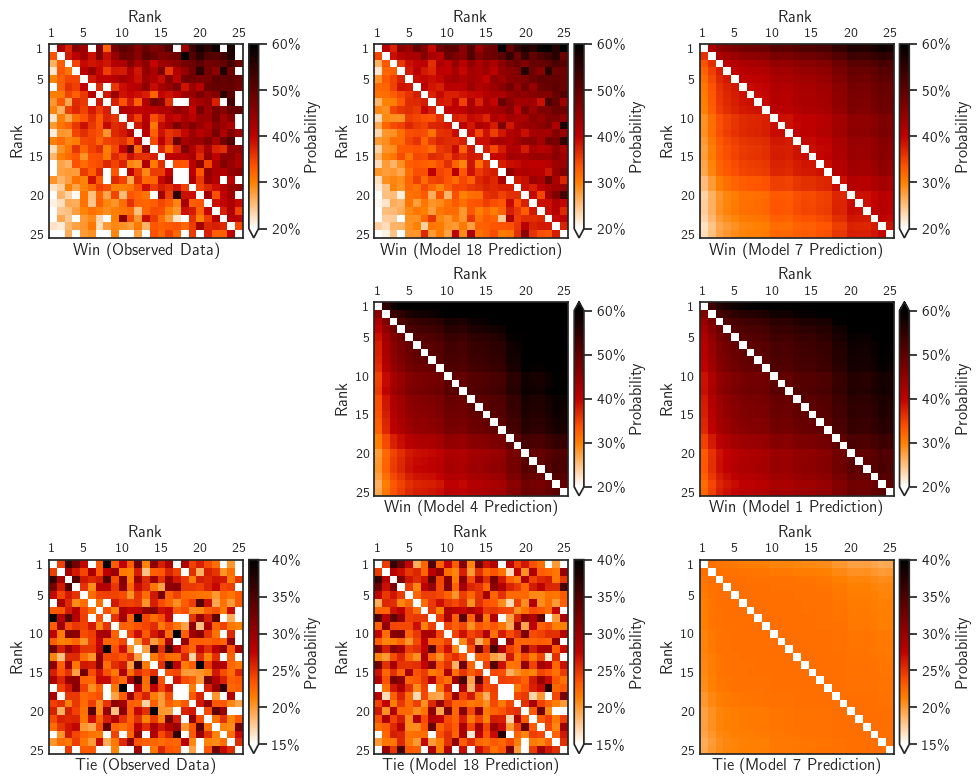

In [44]:
latex = True
save = True
density = True

benchmark_model = models[29]
score = benchmark_model.param[:benchmark_model.n_agents]
rank = np.argsort(score)[::-1]

max_rank = 27
rank = rank[:max_rank]

#model_orders = np.array([30, 18, 26, 14, 22, 10, 6, 3, 19, 7, 4, 1]) - 1
#model_orders = np.array([1, 7, 19, 18, 30]) - 1
model_orders = np.array([1, 4, 7, 18]) - 1

model_orders = model_orders[::-1]

rm_indices = np.array([10, 25]) - 1

with texplot.theme(rc={'font.family': 'sans-serif'}, use_latex=latex, font_scale=1):
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

    for i in range(3):
        for j in range(3):
            ax[i, j].set_visible(False)

    ax = np.array(ax)

    ax[0, 0].set_visible(True)
    plot_match_matrix(ax[0, 0], models[model_orders[0]], rank, density=True,
                      source='observed', kind='win', data_range=[0.2, 0.6],
                      title='Win (Observed Data)',
                      rm_indices=rm_indices, save=save, latex=latex)

    ax[2, 0].set_visible(True)
    plot_match_matrix(ax[2, 0], models[model_orders[0]], rank, density=True,
                      source='observed', kind='tie', data_range=[0.15, 0.4],
                      title='Tie (Observed Data)',
                      rm_indices=rm_indices, save=save, latex=latex)

    for i in range(model_orders.size):

        ax[i // 2, i % 2 + 1].set_visible(True)
        plot_match_matrix(ax[i // 2, i % 2 + 1], models[model_orders[i]], rank, density=True,
                          source='predicted', kind='win', data_range=[0.2, 0.6],
                          title='Win (Model ' + f'{model_orders[i]+1}' + ' Prediction)',
                          rm_indices=rm_indices, save=save, latex=latex)

        if not models[model_orders[i]].__class__.__name__.startswith('BradleyTerry'):
            ax[2, i % 2 + 1].set_visible(True)
            plot_match_matrix(ax[2, i % 2 + 1], models[model_orders[i]], rank, density=True,
                              source='predicted', kind='tie', data_range=[0.15, 0.4],
                              title='Tie (Model ' + f'{model_orders[i]+1}' + ' Prediction)',
                              rm_indices=rm_indices, save=save, latex=latex)

    plt.tight_layout()

    plt.subplots_adjust(hspace=0.33, wspace=0.33)

    texplot.show_or_save_plot(plt, default_filename='match_matrix',
                              transparent_background=False,
                              dpi=200, show_and_save=save,
                              verbose=True)